# Introduction


**ASSIGNMENT DEADLINE: 4 Mar 2019 (MON) 17:00**

In this assignemnt, the task is to implement some basic components for training recurrent neural network over the NLTK dataset. Firstly, you need to implement the RNNCell operations in nn/operations.py, which are used by the layers in [nn/rnn_layers.py](nn/rnn_layer.py). Secondly, you meed to implement the forward and backward function of RNN layer in [nn/rnn_layers.py](nn/rnn_layer.py). Next, you need to implement the forward and backward function of BidirectionalRNN in [nn/rnn_layers.py](nn/rnn_layer.py). Finally, you need to tune the model structure and some hyperparameters to improve the accuracy on sentiment analysis.

**Attention**:
- *Only python3 is allowed to use in this assignment.*
- *`numpy` is utilized for computation.*
- *You do not need a GPU to for this assignment. CPU is enough.*
- *To run this Jupyter notebook, you need to install the depedent libraries as stated in [README.MD](README.MD).*
- *Please do not run this whole file before you implement all the codes. Otherwise some errors will occur.*
- *Please do not change the inputs values of the functions needing to be implemented, otherwise your implementation may be wrong tested by our codes.*
- *After you implement one function, remember to restart the notebook kernel to help it recognize your fresh code.*
- *Please do not change the structure of files in the whole folder of this assignment, otherwise Your marks will be reduced.*
- *You are only allowed to code inside the provided code block, you can not add or modify codes in any other places outside the code block.*

## Structure of Codes

The structure of provided codes and the functionality of its containing files is shown as below:

```bash
codes/
    data/
        corpus.csv      # for nltk dataset 
        dictionary.csv  # for nltk dataset
    models/    # example models of your tiny deep learning framework
        SentimentNet.py     # example model on nltk dataset
    nn/        # components of neural networks
        rnn_layers.py       # layer abstract for RNN, your main workspace
        loss.py         # loss function for optimization
        model.py        # model abstraction for defining and training models
        operations.py   # operation abstraction for defined layers, your another main workspace
        optimizers.py   # optimizing methods
    utils/     # some additional tools
        rnn_check_grads.py  # help you check whether your forward function and backward function are consistent
        datasets.py     # load dataset, like NLTK
        initializers.py # initializing methods to initialize parameters (like weights, bias)
        tools.py        # other useful functions, you can use it in your codes but without any modification to this file
    main.ipynb # interactive notebook, help you understand your task
    README.MD  # requirements to run main.ipynb
```

## Functionality of This Notebook

This iPython notebook serves to:

- explain code structure, main APIs
- explain your task
- provide code to test your implemented forward and backward function for operations and layers

*You can type `jupyter lab` in the terminal to start this jupyter notebook while you are in the folder containing this file. It's much more convinient than jupyter notebook.*

# Your Task

## RNN Cell Operation

RNN cell is the basic building block of RNN, which implements the specific operation at each time step of RNN. It has an hidden states of dimension `H` and accepts inputs of dimension `D`. In this assignment, you are required to implement a simple type of RNN cell, formulated as follows:

\begin{equation*}
y=tanh(Wx+Uh+b),
\end{equation*}

where `x` and `h` are the inputs and hidden states respectively, and `W`, `U` and `b` are trainable kernel, recurrent_kernel and bias respectively.

## Forward

In the file [nn/operations.py](nn/operations.py), implement the forward function for `RNNCellOp` operation. (`input` is a list of two numpy arrays, `[x, h]`). We will help you to test the operation by RNNCell layer, which has been implemented by us.

In [9]:
import numpy as np
import keras
from keras import layers
# import importlib
# rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import RNNCell
from utils.tools import rel_error

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
out = rnn_cell.forward([x, prev_h])
# compare with the keras implementation
keras_x = layers.Input(shape=(1, D), name='x')
keras_prev_h = layers.Input(shape=(H,), name='prev_h')
keras_rnn = layers.RNN(layers.SimpleRNNCell(H),
                       name='rnn')(keras_x, initial_state=keras_prev_h)
keras_model = keras.Model(inputs=[keras_x, keras_prev_h], 
                          outputs=keras_rnn)
keras_model.get_layer('rnn').set_weights([rnn_cell.kernel,
                                          rnn_cell.recurrent_kernel,
                                          rnn_cell.bias])
keras_out = keras_model.predict_on_batch([x[:, None, :], prev_h])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 1.3053608519900442e-07


## Backward

Implement the backward function for the `RNNCellOp` operation in the file [nn/operations.py](nn/operations.py). 

When you are done, restart jupyter notebook and run the following to check your backward pass with a numeric gradient check. 

In [10]:
import numpy as np
from nn.rnn_layers import RNNCell
from utils.rnn_check_grads import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
inputs = [[x, prev_h]]

check_grads_layer(rnn_cell, [x, prev_h], in_grads)

Gradient to input 0: correct
Gradient to input 1: correct
Gradient to -:rnn_cell/kernel: correct
Gradient to -:rnn_cell/recurrent_kernel: correct
Gradient to -:rnn_cell/bias: correct


Then please improve your implementation of RNN cell so that it can properly handle `NaN` input, and test it with the following code. **In forward pass, the corresponding output units are supposed to be `NaN` as well; in backward pass, the gradients to those `NaN` input units are supposed to be zeros.**

In [2]:
import numpy as np
from nn.rnn_layers import RNNCell
from utils.rnn_check_grads import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
# set part of input to NaN
# this situation will be encountered in the following work
x[1:, :] = np.nan
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
check_grads_layer(rnn_cell, [x, prev_h], in_grads)

Gradient to input 0: correct
Gradient to input 1: correct
Gradient to -:rnn_cell/kernel: correct
Gradient to -:rnn_cell/recurrent_kernel: correct
Gradient to -:rnn_cell/bias: correct


## RNN Layer

RNN layer wraps any type of RNN cell so that it can operate over a sequence of input data of different length. In particular, it runs a instance of RNN cell over the inputs, holds and updates the hidden states for the RNN cell. In this assignment, you are required to implement such a general RNN layer that is able to wrap your implemented RNN cell above.

## Forward

Please implement the function `RNN.forward(self, inputs)` in [nn/rnn_layers.py](nn/rnn_layers.py) and test your implementation using the following code. Since NN layers generally proceed on a batch of data simultaneously, and for RNN, each input data may have different length, we define the input data format as an array of `(N, T, D)`, where `N` is the number of samples in a batch, `T` is the maximum length of input sequences, and `D` is the dimension of features at each time step. `NaN` is used to pad input sequences of different lenghts, so that the resulting length equals to `T`, e.g. `(x1, x2, ..., xk, NaN, NaN)`. **Tips: you can utilze `np.nan_to_num(x)` to easily convert NaNs to zeros in a numpy array, and `np.isnan(x)` to get binary mask indicating which elements are NaNs.**

In [8]:
import numpy as np
import keras
from keras import layers
from nn.rnn_layers import RNN
from utils.tools import rel_error

import warnings
warnings.simplefilter('ignore', RuntimeWarning)

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))

rnn = RNN(in_features=D, units=H, h0=h0)
out = rnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True,
                       name='rnn')(keras_x, initial_state=keras_h0)
keras_model = keras.Model(inputs=[keras_x, keras_h0],
                          outputs=keras_rnn)
keras_model.get_layer('rnn').set_weights([rnn.kernel,
                                          rnn.recurrent_kernel,
                                          rnn.bias])
keras_out = keras_model.predict_on_batch([x, np.tile(h0, (N, 1))])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 4.1498337682303687e-07


## Backward

Please implement the function `RNN.backward(self, in_grads, inputs)` in [nn/rnn_layers.py](nn/rnn_layers.py) and test your implementation using the following code (**note the internal gradients passed from next time steps**). Once again: the gradients to those `NaN` input units are supposed to be zeros

In [2]:
import numpy as np
# import importlib
# import rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import RNN
from utils.rnn_check_grads import check_grads_layer

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
in_grads = np.random.uniform(size=(N, T, H))

rnn = RNN(in_features=D, units=H)
check_grads_layer(rnn, x, in_grads)

Gradient to input: correct
Gradient to -:rnn/kernel: correct
Gradient to -:rnn/recurrent_kernel: correct
Gradient to -:rnn/bias: correct


# Bi-directional RNN Layer

Vallina RNN operates over input sequence in one direction, so it has limitations as the future input information cannot be reached from the current state. On the contrary, Bi-directional RNN addresses this shortcoming by operating the input sequence in both forward and backward directions. 

Usually, Bi-directional RNN is implemented by running two independent RNNs in opposite direction of input data, and concatenating the outputs of the two RNNs. Since you have implemented RNN layer above, implementing Bi-directional RNN layer is not hard, which just requires certain manipulation of input data. A useful function that can reverse a batch of sequence data is provided for your easy implementation.

```python
def _reverse_temporal_data(self, x, mask):
    num_nan = np.sum(~mask, axis=1)
    reversed_x = np.array(x[:, ::-1, :])
    for i in range(num_nan.size):
        reversed_x[i] = np.roll(reversed_x[i], x.shape[1]-num_nan[i], axis=0)
    return reversed_x
```

## Forward

Please implement `BidirectionalRNN.forward(self, inputs)` [nn/rnn_layers.py](nn/rnn_layers.py) and use the following code for testing. Note that `H` is the dimension of the hidden states of one internal RNN, so the actual dimension of the hidden states (or outputs) of Bidirectional RNN is `2*H`.

In [11]:
import numpy as np
import keras
from keras import layers
# import importlib
# import rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import BidirectionalRNN
from utils.tools import rel_error

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))
hr = np.random.uniform(size=(H,))

brnn = BidirectionalRNN(in_features=D, units=H, h0=h0, hr=hr)
out = brnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_hr = layers.Input(shape=(H,), name='hr')
keras_x_masked = layers.Masking(mask_value=0.)(keras_x)
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True)
keras_brnn = layers.Bidirectional(keras_rnn, merge_mode='concat', name='brnn')(
        keras_x_masked, initial_state=[keras_h0, keras_hr])
keras_model = keras.Model(inputs=[keras_x, keras_h0, keras_hr],
                          outputs=keras_brnn)
keras_model.get_layer('brnn').set_weights([brnn.forward_rnn.kernel,
                                           brnn.forward_rnn.recurrent_kernel, 
                                           brnn.forward_rnn.bias,
                                           brnn.backward_rnn.kernel, 
                                           brnn.backward_rnn.recurrent_kernel,
                                           brnn.backward_rnn.bias])
keras_out = keras_model.predict_on_batch([np.nan_to_num(x), np.tile(h0, (N, 1)), np.tile(hr, (N, 1))])
nan_indices = np.where(np.any(np.isnan(x), axis=2))
keras_out[nan_indices[0], nan_indices[1], :] = np.nan

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 5.728964999517614e-08


## Backward

Please refer to the provided forward function and implement the function `BidirectionalRNN.backward(self, inputs)` in [nn/rnn_layers.py](nn/rnn_layers.py). Test your implementation using the following code.

In [12]:
import numpy as np
# import importlib
# import rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import BidirectionalRNN
from utils.rnn_check_grads import check_grads_layer

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
in_grads = np.random.uniform(size=(N, T, H*2))

brnn = BidirectionalRNN(in_features=D, units=H)
check_grads_layer(brnn, x, in_grads)

Gradient to input: correct
Gradient to -:brnn/forward_kernel: correct
Gradient to -:brnn/forward_recurrent_kernel: correct
Gradient to -:brnn/forward_bias: correct
Gradient to -:brnn/backward_kernel: correct
Gradient to -:brnn/backward_recurrent_kernel: correct
Gradient to -:brnn/backward_bias: correct


# Sentiment Analysis using RNNs

In this section, you are required to test your implementations above by running an ensemble NN on a sentiment analysis dataset. The dataset, `data/corpus.csv`, consists of 800 real movie comments and the corresponding labels that indicate whether the comments are positive or negative. For example:
```
POSTIVE: I absolutely LOVE Harry Potter, as you can tell already.
NEGATIVE: My dad's being stupid about brokeback mountain...
```

We provide a basic NN for your experiments, which can be found in `applications.py`. The architecture is as follow:
```python
FCLayer(vocab_size, 200, name='embedding')
BidirectionalRNN(RNNCell(in_features=200, units=50))
FCLayer(100, 32, name='fclayer1')
TemporalPooling()
FCLayer(32, 2, name='fclayer2')
```
The input to the network is sequences of one-hot vectors, each of which represents a word. The 1st FC layer works as an [embedding layer](https://www.tensorflow.org/versions/master/programmers_guide/embedding) to learn and retrieve the word embedding vectors. After a Bi-directional RNN layer and another FC layer, a TemporalPooling layer (see `layers.py`) is used to mean-pooling a sequence of vectors into one vector, which will ignore the filling `NaN`s. The rest of the network is same as a normal NN classifier.

In [5]:
from utils import datasets
from models.SentimentNet import SentimentNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.001, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=5, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

[nltk_data] Downloading package punkt to /Users/shuyao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of training samples: 600
Number of validation samples: 100
Number of testing samples: 100
Epoch 0: 
Train iter 5/30:	acc 0.75, loss 0.69, reg loss 0.00, speed 101.50 imgs/sec
Train iter 10/30:	acc 0.75, loss 0.68, reg loss 0.00, speed 125.04 imgs/sec
Train iter 15/30:	acc 0.55, loss 0.68, reg loss 0.00, speed 124.88 imgs/sec
Train iter 20/30:	acc 0.60, loss 0.56, reg loss 0.00, speed 122.87 imgs/sec
Test acc 0.86, loss 0.37
Train iter 25/30:	acc 0.85, loss 0.30, reg loss 0.01, speed 70.51 imgs/sec
Epoch 1: 
Train iter 5/30:	acc 0.95, loss 0.15, reg loss 0.02, speed 103.95 imgs/sec
Train iter 10/30:	acc 0.95, loss 0.08, reg loss 0.03, speed 125.65 imgs/sec
Train iter 15/30:	acc 1.00, loss 0.06, reg loss 0.03, speed 125.08 imgs/sec
Train iter 20/30:	acc 1.00, loss 0.05, reg loss 0.03, speed 126.04 imgs/sec
Test acc 0.96, loss 0.09
Train iter 25/30:	acc 1.00, loss 0.01, reg loss 0.03, speed 71.63 imgs/sec
Epoch 2: 
Train iter 5/30:	acc 1.00, loss 0.04, reg loss 0.03, speed 104.16 i

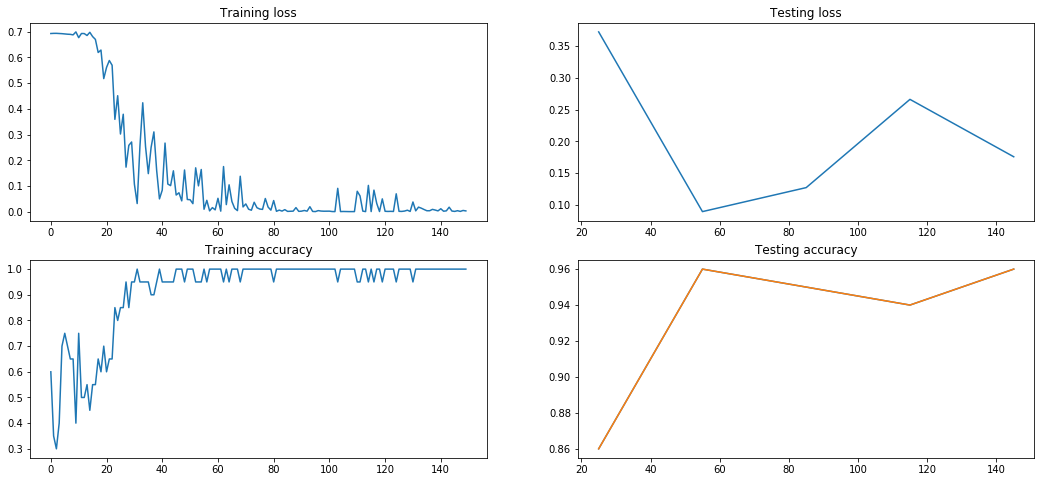

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])

# Train your best SentimenNet!
Tweak the hyperparameters and structure of the SentimentNet. The network is small, hence the training should finish quickly using your CPU (less than 1 hour). 

In [ ]:
# define your new model and all training codes here, like loading data, defining optimizer and so on

# ...


## Your Description and Analysis
Please write down what you have tuned for your best SentimentNet. And please write down your analysis about their impacts on performance.

-----------------------------------

write here (remove it before writing your description and analysis)

-----------------------------------

# Marking Scheme

Marking scheme is shown below:
- 5 marks for `RNNCellOp` forward and backward function
- 5 marks for `RNN` forward and backward function
- 5 marks for `BidirectionalRNN` forward and backward function
- 4 marks for tuning your best SentimentNet
- 1 marks for your submission format

For submission format, please follow below submission instructions.

**DO NOT** use external libraries like Tensorflow, keras and Pytorch in your implementation. **DO NOT** copy the code from the internet, e.g. github. We have offered all materials that you can refer to in this notebook.

# Final submission instructions
Please submit the following:

1) Your codes in a folder named `codes`, and keep the structure of all files in this folder the same as what we have provided. 

**ASSIGNMENT DEADLINE: 4 Mar 2019 (MON) 17:00**

Do not include the `data` folder as it takes up substantial memory. Please zip up the following folders under a folder named with your NUSNET ID: eg. `e0123456g.zip` and submit the zipped folder to LumiNUS/Files/Assignment 1 Submission. If unzip the file, the structure should be like this:

```bash
e0123456g/
    codes/
        models/
            ...
        nn/
            ...
        utils/
            ...
        main.ipynb
        README.MD
```